Here is the Persistence model, which is essentially not a model:
The price at next day will be simply predicted with the proce today.

I put it here as a baseline. 

In [1]:
import numpy as np
import math

import pandas as pd
import pandas_datareader as pdr

from datetime import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import itertools
import numpy as np
#import yfinance as yf

from matplotlib import pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

/home/haowei/usr/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# common setting for all models
ticker = 'FSLR'
splitting = 0.2,0.2 # for valication, testing, and the rest for training
metrics = pd.DataFrame()

def forecast_metrics(y_true, y_pred, algo='Algo'):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # MAPE
    smape = 200 * np.mean((np.abs(y_pred - y_true)
                    / (np.abs(y_pred) + np.abs(y_true))))
    corr = np.corrcoef(y_pred, y_true)[0,1]   # corr
    mins = np.amin(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    maxs = np.amax(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    minmax = 100*(1 - np.mean(mins/maxs))             # minmax
    return pd.DataFrame({'RMSE': rmse,
                         'MAPE': mape,
                         'SMAPE': smape,
                         'MinMax': minmax,
                         'Corr': corr
                        }, index=[algo]
          )

data = pd.read_csv('data/{0}.csv'.format(ticker.lower()), parse_dates=['date'])
data.sort_values(by='date', inplace=True, ascending=True) # not needed, but to make sure

ndata = len(data)
ntest = int(ndata * splitting[-1])
nval = int(ndata * splitting[-2])
ntrain = ndata - ntest - nval
ntrval = ntrain + nval

train = data[:ntrain]
val = data[ntrain:ntrain+nval]
train_val = data[:ntrain+nval] # convinient
test = data[ntrain+nval:]
print("Dataset Size:")
print("Train: {} | Validation: {} | Test: {}".format(train.shape[0],
                                                       val.shape[0],
                                                      test.shape[0]))

data.head(5)

Dataset Size:
Train: 891 | Validation: 297 | Test: 297


,date,high,low,open,close,volume,adj_close
0,2014-01-02,57.580002,54.009998,54.279999,57.439999,5404200,57.439999
1,2014-01-03,58.299999,55.849998,57.590000,56.740002,4118700,56.740002
2,2014-01-06,54.630001,51.009998,54.250000,51.259998,11791700,51.259998
3,2014-01-07,53.889999,52.060001,52.150002,52.490002,6661900,52.490002
4,2014-01-08,52.889999,51.410000,52.290001,51.680000,4930200,51.680000


### EDA

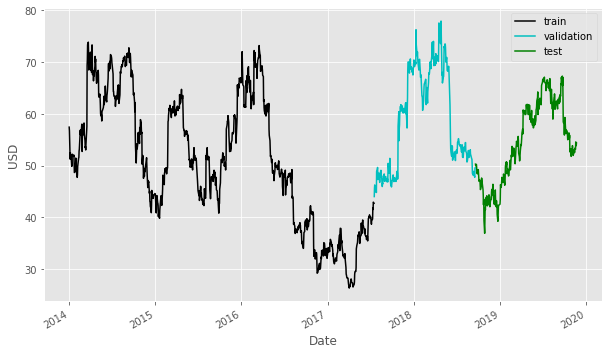

In [3]:
fig,ax=plt.subplots(figsize=(10,6))
for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax = d.plot(x='date', y='adj_close', style=s, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")
plt.show();

### Modelling

In [4]:
def get_preds_lin_reg(df, target_col, N, pred_min, start):
    """built a linear regression model, with the count of days as X, the price as y."""
    
    regr = LinearRegression(fit_intercept=True)  # so no new column with value 1.0 needed

    pred_list = []

    for i in range(start, len(df[target_col])):
        X_train = np.array(range(len(df[target_col][i-N:i])))
        y_train = np.array(df[target_col][i-N:i])

        X_train = X_train.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)

        regr.fit(X_train, y_train)
        pred = regr.predict( [[N]] )
    
        pred_list.append(pred[0][0]) 
    
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

In [5]:
metrics = pd.DataFrame()

Nmax = 20
for N in range(1, Nmax+1): 
    y_pred = get_preds_lin_reg(train_val, 'adj_close', N, 0, ntrain)
    
    val[f'forcast_{N}'] = y_pred
    m = forecast_metrics(val.adj_close, y_pred, N)
    metrics = metrics.append(m)

print(metrics)
Nopt = metrics.MAPE.idxmin()

        RMSE      MAPE     SMAPE    MinMax      Corr
1   1.605851  1.804380  1.807754  1.773259  0.986010
2   2.231087  2.532134  2.533455  2.467732  0.974006
3   2.087450  2.362499  2.361228  2.304655  0.977040
4   2.015270  2.366355  2.364784  2.311641  0.978534
5   2.027079  2.399036  2.400488  2.346498  0.978258
6   2.057743  2.436824  2.441895  2.386400  0.977590
7   2.097061  2.476586  2.484115  2.426440  0.976740
8   2.146538  2.555953  2.565459  2.504497  0.975657
9   2.227178  2.676352  2.687671  2.622170  0.973828
10  2.312409  2.813000  2.823894  2.753679  0.971819
11  2.375582  2.924059  2.933820  2.859862  0.970290
12  2.435931  3.028614  3.037427  2.959676  0.968796
13  2.489971  3.101446  3.109559  3.028397  0.967437
14  2.533613  3.145956  3.154083  3.070067  0.966333
15  2.580047  3.191365  3.199861  3.112734  0.965141
16  2.632578  3.224044  3.232825  3.142224  0.963766
17  2.678731  3.275165  3.283320  3.189367  0.962544
18  2.723674  3.333845  3.340866  3.243488  0.

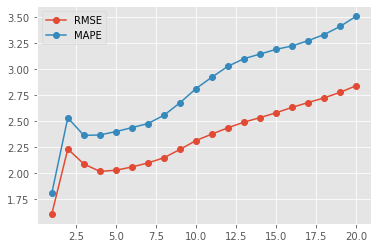

In [6]:
metrics[['RMSE', 'MAPE']].plot(style='o-');

### Plotting on Valication set

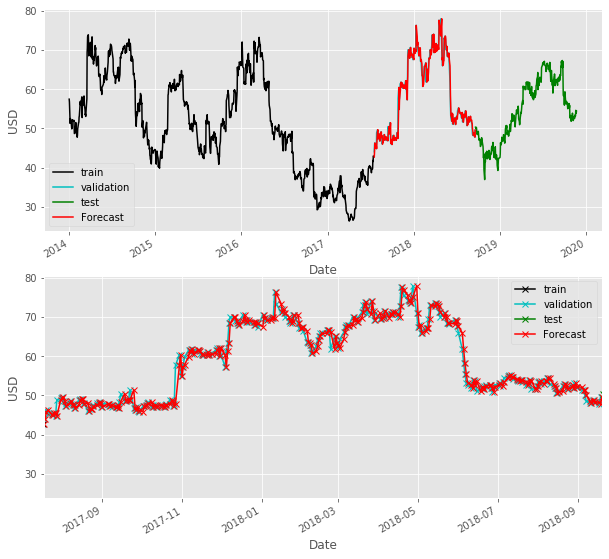

In [7]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(val.date, val[f'forcast_{Nopt}'], 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(val.date, val[f'forcast_{Nopt}'], 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([val.date.min(), val.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

### Final model, test set

In [8]:
metrics = pd.DataFrame()

y_pred = get_preds_lin_reg(data, 'adj_close', Nopt, 0, ntrval)
test[f'forcast'] = y_pred
m = forecast_metrics(test.adj_close, y_pred, Nopt)
metrics = metrics.append(m)

print(metrics)

       RMSE      MAPE     SMAPE    MinMax      Corr
1  1.257067  1.746816  1.744315  1.716753  0.986942


### Plotting on test set

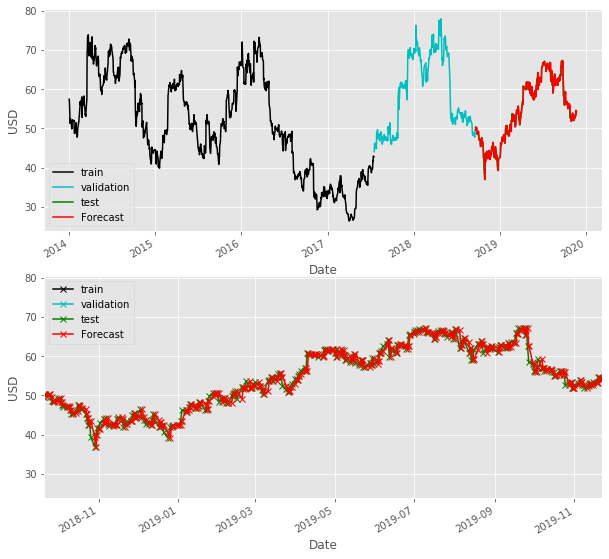

In [9]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(test.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(test.date, y_pred, 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([test.date.min(), test.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

### Save predictions

In [10]:
test.to_csv("./out/test_lin_reg.csv")

### Findings

* For FSLR, the linear regression model essentially goes back to the persistence model, 